In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
    .appName("EDA for Silver Layer")\
    .config("spark.hadoop.fs.defaultFS", "hdfs://localhost:9000")\
    .config("spark.sql.legacy.timeParserPolicy", "LEGACY") \
    .getOrCreate()

In [2]:
yfinance_silver_path = "/user/adam_majczyk2001/nifi/silver_parquet/yfinance/"
news_silver_path = "/user/adam_majczyk2001/nifi/silver_parquet/news/"

In [3]:
yfinance_df = spark.read.parquet(yfinance_silver_path)
news_df = spark.read.parquet(news_silver_path)

## 1. news_df

In [4]:
news_df.show(truncate=False)

+-------------------------------------------------------------------------------------------+--------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+-----------+-----------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [5]:
news_df.printSchema()

root
 |-- title: string (nullable = true)
 |-- datetime: string (nullable = true)
 |-- keywords: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- is_premium: boolean (nullable = true)
 |-- source_site: string (nullable = true)
 |-- url: string (nullable = true)
 |-- text: string (nullable = true)
 |-- random: string (nullable = true)



In [6]:
print(f"Number of rows in news_df: {news_df.count()}")

Number of rows in news_df: 979


In [7]:
# Check max and min datetime in news_df
news_df.agg({"datetime": "max"}).show()
news_df.agg({"datetime": "min"}).show()

+--------------------+
|       max(datetime)|
+--------------------+
|2025-01-03T00:00:...|
+--------------------+



+--------------------+
|       min(datetime)|
+--------------------+
|2020-11-18T00:00:...|
+--------------------+



In [8]:
from pyspark.sql.functions import col, count

news_nulls = news_df.select([
    (count(col(c)) - news_df.count()).alias(c) for c in news_df.columns
])

news_nulls.show()

+-----+--------+--------+----------+-----------+---+----+------+
|title|datetime|keywords|is_premium|source_site|url|text|random|
+-----+--------+--------+----------+-----------+---+----+------+
|    0|       0|       0|         0|          0|  0|  -6|     0|
+-----+--------+--------+----------+-----------+---+----+------+



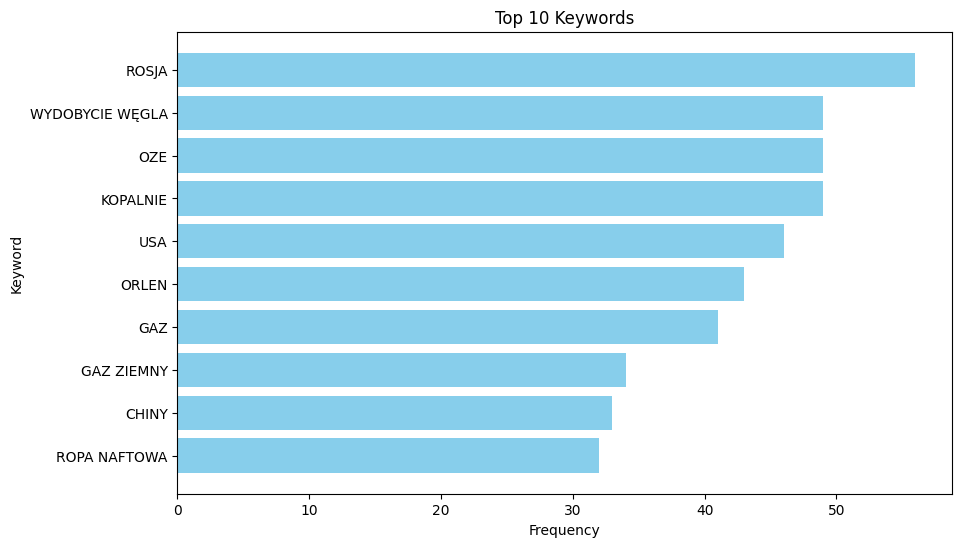

In [9]:
from pyspark.sql.functions import explode
import pandas as pd
import matplotlib.pyplot as plt

keywords_df = news_df.select(explode(col("keywords")).alias("keyword")).groupBy("keyword").count().orderBy(col("count").desc()).toPandas()

plt.figure(figsize=(10, 6))
plt.barh(keywords_df['keyword'].head(10), keywords_df['count'].head(10), color='skyblue')
plt.title('Top 10 Keywords')
plt.xlabel('Frequency')
plt.ylabel('Keyword')
plt.gca().invert_yaxis()
plt.show()

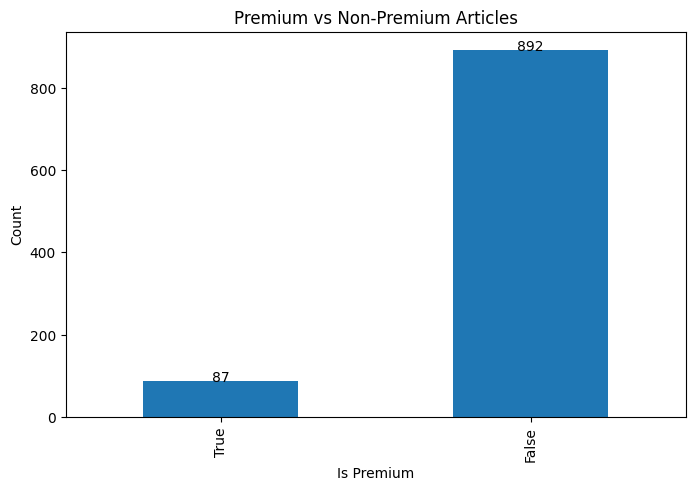

In [10]:
premium_counts = news_df.groupBy("is_premium").count().toPandas()
premium_counts.plot(kind='bar', x='is_premium', y='count', legend=False, figsize=(8, 5))
# Display count on top of each bar
for i in range(premium_counts.shape[0]):
    plt.text(i, premium_counts.iloc[i]['count'], premium_counts.iloc[i]['count'], ha = 'center')
plt.title('Premium vs Non-Premium Articles')
plt.xlabel('Is Premium')
plt.ylabel('Count')
plt.show()

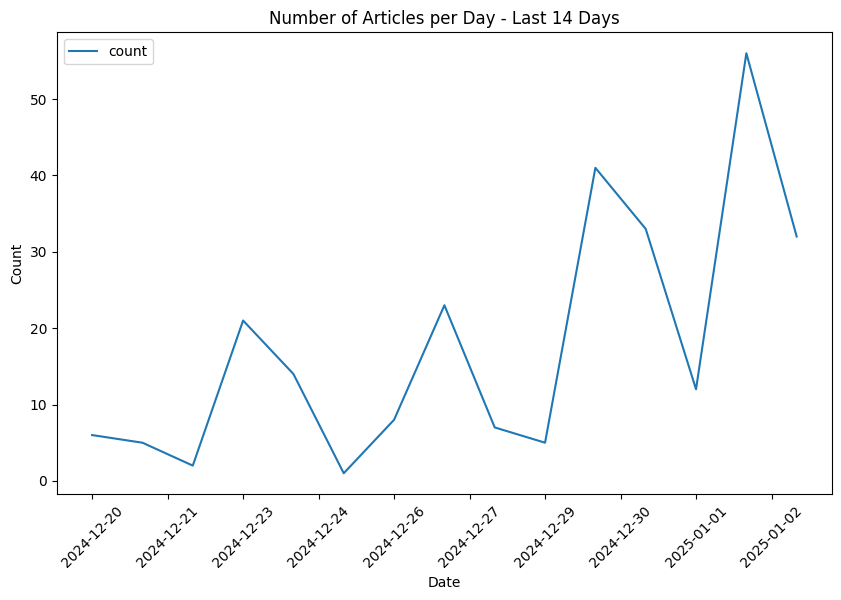

In [11]:
from pyspark.sql.functions import to_date, current_date, date_sub

# Number of articles per day
news_df.withColumn("datetime", to_date("datetime")).filter(news_df["datetime"] >= date_sub(current_date(), 14)).groupBy("datetime").count().orderBy("datetime").toPandas().plot(x="datetime", y="count", figsize=(10, 6))
plt.title('Number of Articles per Day - Last 14 Days')
plt.xlabel('Date')
plt.ylabel('Count')
plt.xticks(rotation=45)
# xticks each day
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(15))
plt.show()

## 2. yfinance_df

In [12]:
yfinance_df.show(truncate=False)

+--------------------------+------+--------+----------+--------------+----------------+----------------+--------------------------+---------+-------+
|record_timestamp          |price |volume  |volatility|bid_ask_spread|market_sentiment|trading_activity|update_timestamp          |source   |company|
+--------------------------+------+--------+----------+--------------+----------------+----------------+--------------------------+---------+-------+
|2024-11-24T20:17:39.243508|65.58 |3884324 |0.578     |0.0341        |-0.752          |65.06           |2024-11-24T20:12:39.583619|simulated|SHEL   |
|2024-11-24T20:17:39.243508|29.67 |16368838|1.513     |0.0136        |-0.426          |46.16           |2024-11-24T20:12:42.501631|simulated|BP     |
|2024-11-24T20:17:39.243508|122.1 |6527058 |1.339     |0.0581        |-0.679          |82.58           |2024-11-24T20:12:43.978946|simulated|XOM    |
|2024-11-24T20:17:39.243508|29.67 |16554556|1.539     |0.0138        |-0.372          |46.55        

In [13]:
yfinance_df.printSchema()

root
 |-- record_timestamp: string (nullable = true)
 |-- price: double (nullable = true)
 |-- volume: integer (nullable = true)
 |-- volatility: double (nullable = true)
 |-- bid_ask_spread: double (nullable = true)
 |-- market_sentiment: double (nullable = true)
 |-- trading_activity: double (nullable = true)
 |-- update_timestamp: string (nullable = true)
 |-- source: string (nullable = true)
 |-- company: string (nullable = true)



In [14]:
print(f"Number of rows in yfinance_df: {yfinance_df.count()}")

Number of rows in yfinance_df: 475206


In [15]:
yfinance_df.agg({"update_timestamp": "max"}).show()
yfinance_df.agg({"update_timestamp": "min"}).show()

+---------------------+
|max(update_timestamp)|
+---------------------+
| 2025-01-03T21:34:...|
+---------------------+

+---------------------+
|min(update_timestamp)|
+---------------------+
| 2024-11-24T20:12:...|
+---------------------+



In [16]:
yfinance_nulls = yfinance_df.select([
    (count(col(c)) - yfinance_df.count()).alias(c) for c in yfinance_df.columns
])

yfinance_nulls.show()

+----------------+-----+------+----------+--------------+----------------+----------------+----------------+------+-------+
|record_timestamp|price|volume|volatility|bid_ask_spread|market_sentiment|trading_activity|update_timestamp|source|company|
+----------------+-----+------+----------+--------------+----------------+----------------+----------------+------+-------+
|               0|    0|     0|         0|             0|               0|               0|               0|     0|      0|
+----------------+-----+------+----------+--------------+----------------+----------------+----------------+------+-------+



In [17]:
from pyspark.sql.functions import min, max, mean, stddev, round

# Aggregate statistics for numeric columns grouped by "company"
numeric_stats = yfinance_df.groupBy("company").agg(
    min("price").alias("min_price"),
    max("price").alias("max_price"),
    mean("price").alias("mean_price"),
    stddev("price").alias("stddev_price"),
    min("volume").alias("min_volume"),
    max("volume").alias("max_volume"),
    mean("volume").alias("mean_volume"),
    stddev("volume").alias("stddev_volume"),
    min("volatility").alias("min_volatility"),
    max("volatility").alias("max_volatility"),
    mean("volatility").alias("mean_volatility"),
    stddev("volatility").alias("stddev_volatility"),
    min("bid_ask_spread").alias("min_bid_ask_spread"),
    max("bid_ask_spread").alias("max_bid_ask_spread"),
    mean("bid_ask_spread").alias("mean_bid_ask_spread"),
    stddev("bid_ask_spread").alias("stddev_bid_ask_spread"),
    mean("market_sentiment").alias("mean_market_sentiment"),
    stddev("market_sentiment").alias("stddev_market_sentiment"),
    mean("trading_activity").alias("mean_trading_activity"),
    stddev("trading_activity").alias("stddev_trading_activity")
)

# Round results to 2 decimal places
numeric_stats_rounded = numeric_stats.select(
    "company",
    round(col("min_price"), 2).alias("min_price"),
    round(col("max_price"), 2).alias("max_price"),
    round(col("mean_price"), 2).alias("mean_price"),
    round(col("stddev_price"), 2).alias("stddev_price"),
    round(col("min_volume"), 2).alias("min_volume"),
    round(col("max_volume"), 2).alias("max_volume"),
    round(col("mean_volume"), 2).alias("mean_volume"),
    round(col("stddev_volume"), 2).alias("stddev_volume"),
    round(col("min_volatility"), 2).alias("min_volatility"),
    round(col("max_volatility"), 2).alias("max_volatility"),
    round(col("mean_volatility"), 2).alias("mean_volatility"),
    round(col("stddev_volatility"), 2).alias("stddev_volatility"),
    round(col("min_bid_ask_spread"), 2).alias("min_bid_ask_spread"),
    round(col("max_bid_ask_spread"), 2).alias("max_bid_ask_spread"),
    round(col("mean_bid_ask_spread"), 2).alias("mean_bid_ask_spread"),
    round(col("stddev_bid_ask_spread"), 2).alias("stddev_bid_ask_spread"),
    round(col("mean_market_sentiment"), 2).alias("mean_market_sentiment"),
    round(col("stddev_market_sentiment"), 2).alias("stddev_market_sentiment"),
    round(col("mean_trading_activity"), 2).alias("mean_trading_activity"),
    round(col("stddev_trading_activity"), 2).alias("stddev_trading_activity")
)

# Show the results
numeric_stats_rounded.show()


25/01/03 22:02:35 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+---------+---------+----------+------------+----------+----------+-----------+-------------+--------------+--------------+---------------+-----------------+------------------+------------------+-------------------+---------------------+---------------------+-----------------------+---------------------+-----------------------+
|company|min_price|max_price|mean_price|stddev_price|min_volume|max_volume|mean_volume|stddev_volume|min_volatility|max_volatility|mean_volatility|stddev_volatility|min_bid_ask_spread|max_bid_ask_spread|mean_bid_ask_spread|stddev_bid_ask_spread|mean_market_sentiment|stddev_market_sentiment|mean_trading_activity|stddev_trading_activity|
+-------+---------+---------+----------+------------+----------+----------+-----------+-------------+--------------+--------------+---------------+-----------------+------------------+------------------+-------------------+---------------------+---------------------+-----------------------+---------------------+-----------

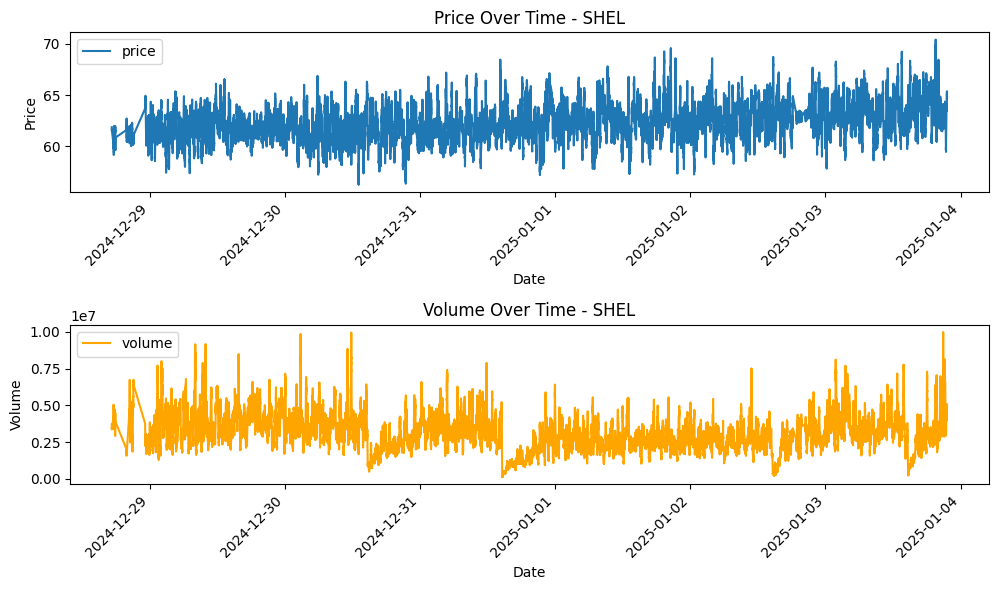

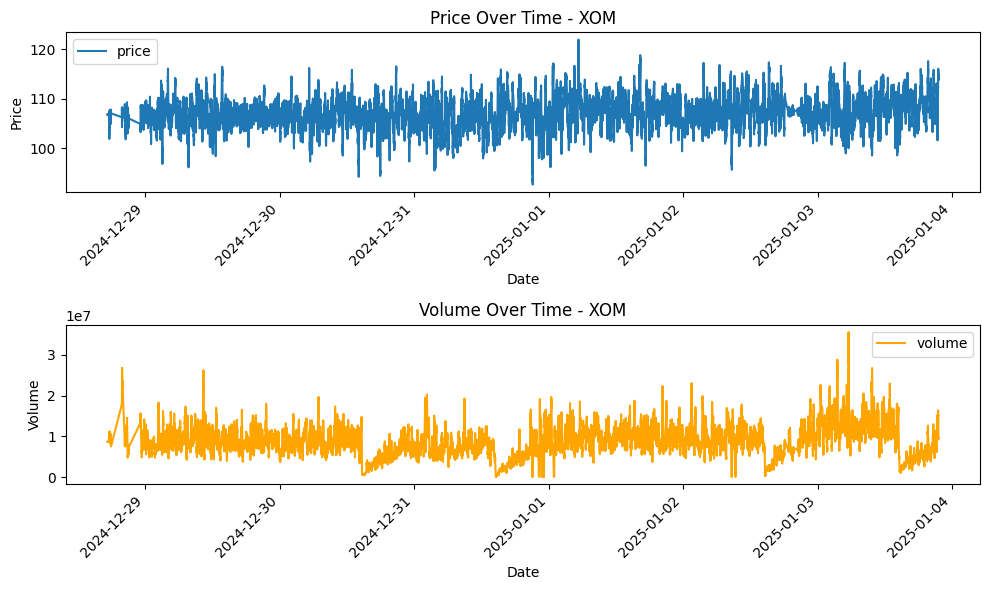

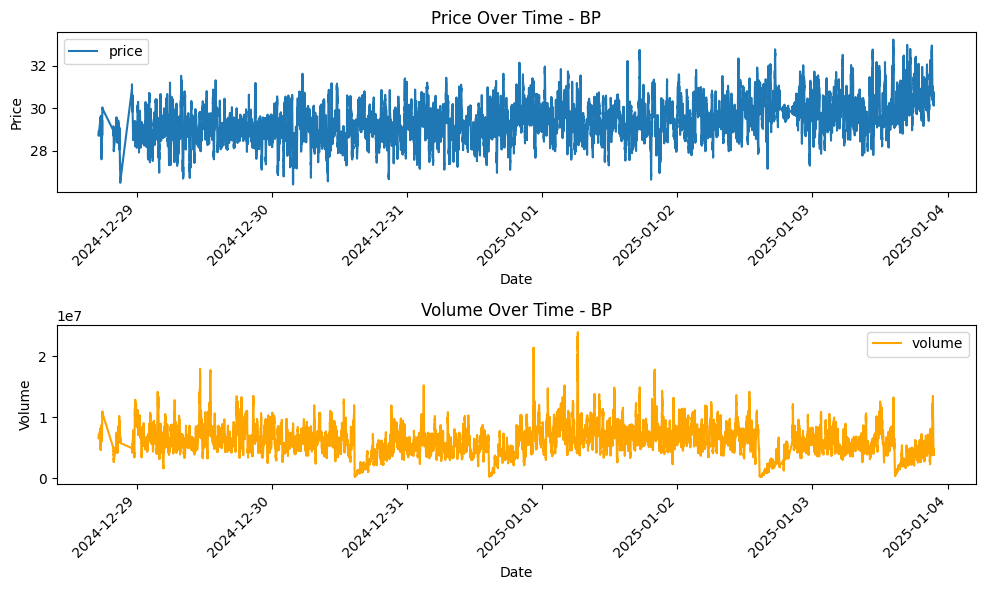

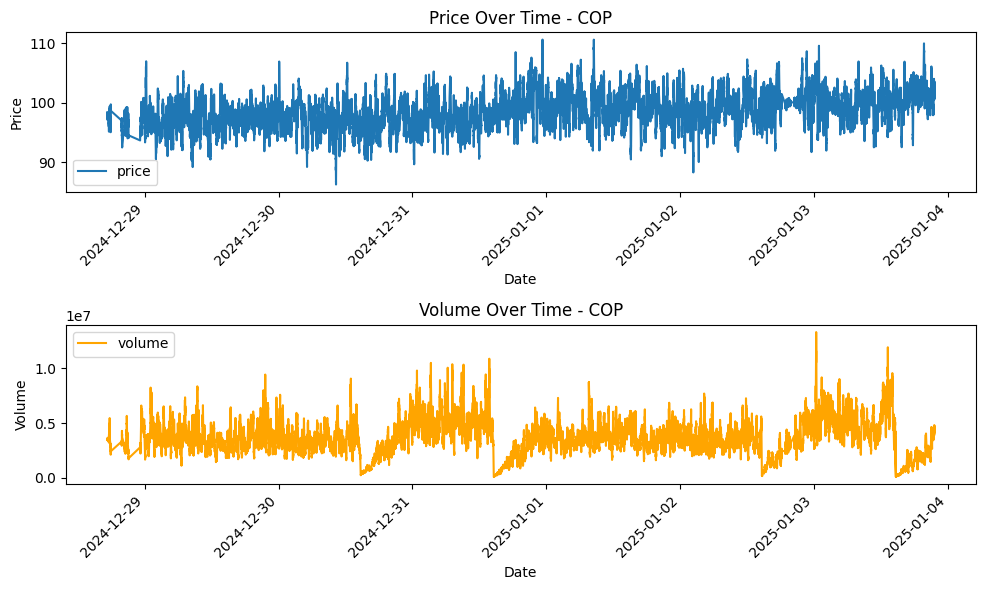

In [22]:
from pyspark.sql.functions import col, to_timestamp, current_timestamp, date_sub
import matplotlib.dates as mdates

# Get distinct company names
companies = yfinance_df.select("company").distinct().rdd.flatMap(lambda x: x).collect()

# Price and Volume plots
for company in companies:
    # Filter data for the last 14 days and convert to Pandas DataFrame
    company_df = (
        yfinance_df
        .withColumn("update_timestamp", to_timestamp(col("update_timestamp")))  # Ensure it's a timestamp
        .filter(col("update_timestamp") >= date_sub(current_timestamp(), 14))
        .filter(col("company") == company)
        .orderBy("update_timestamp")  # Sort by timestamp
        .toPandas()
    )

    fig, axs = plt.subplots(2, 1, figsize=(10, 6))

    # Plot Price
    company_df.plot(x="update_timestamp", y="price", ax=axs[0])
    axs[0].set_title(f"Price Over Time - {company}")
    axs[0].set_xlabel("Date")
    axs[0].set_ylabel("Price")
    axs[0].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))  # Format dates
    axs[0].tick_params(axis='x', rotation=45)

    # Plot Volume
    company_df.plot(x="update_timestamp", y="volume", ax=axs[1], color="orange")
    axs[1].set_title(f"Volume Over Time - {company}")
    axs[1].set_xlabel("Date")
    axs[1].set_ylabel("Volume")
    axs[1].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))  # Format dates
    axs[1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

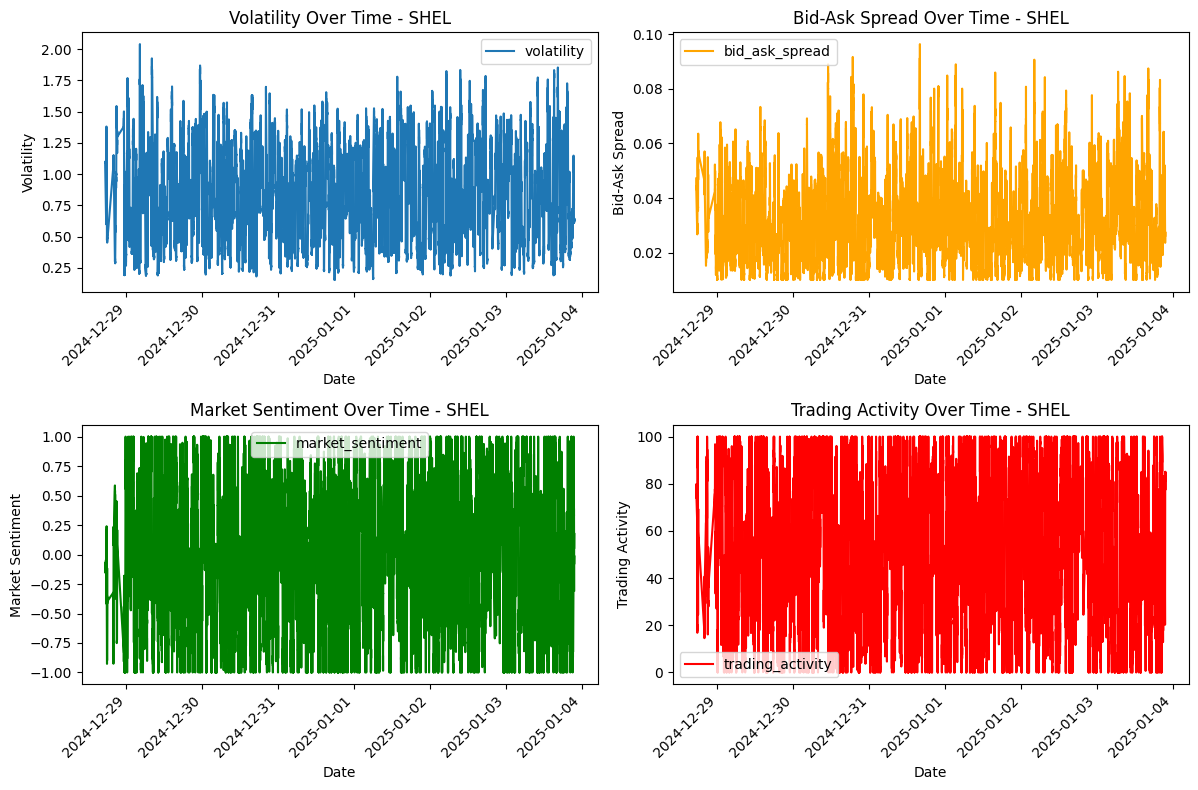

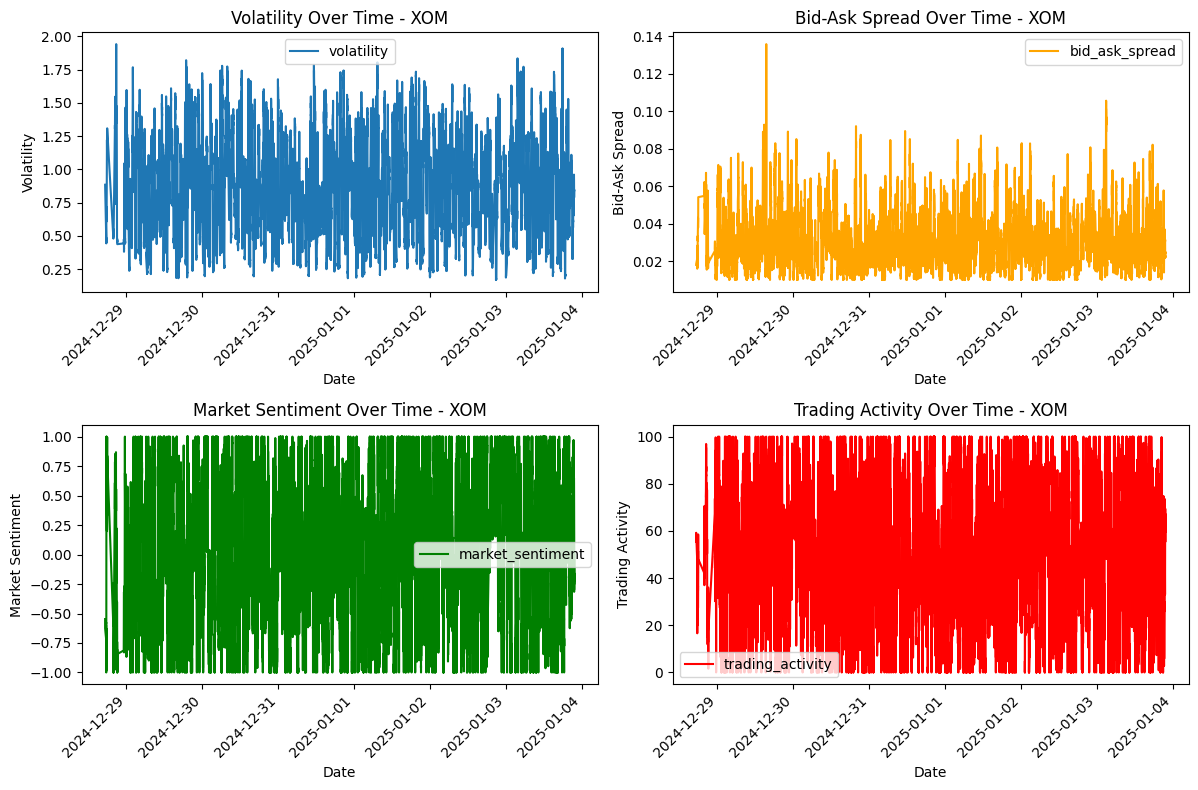

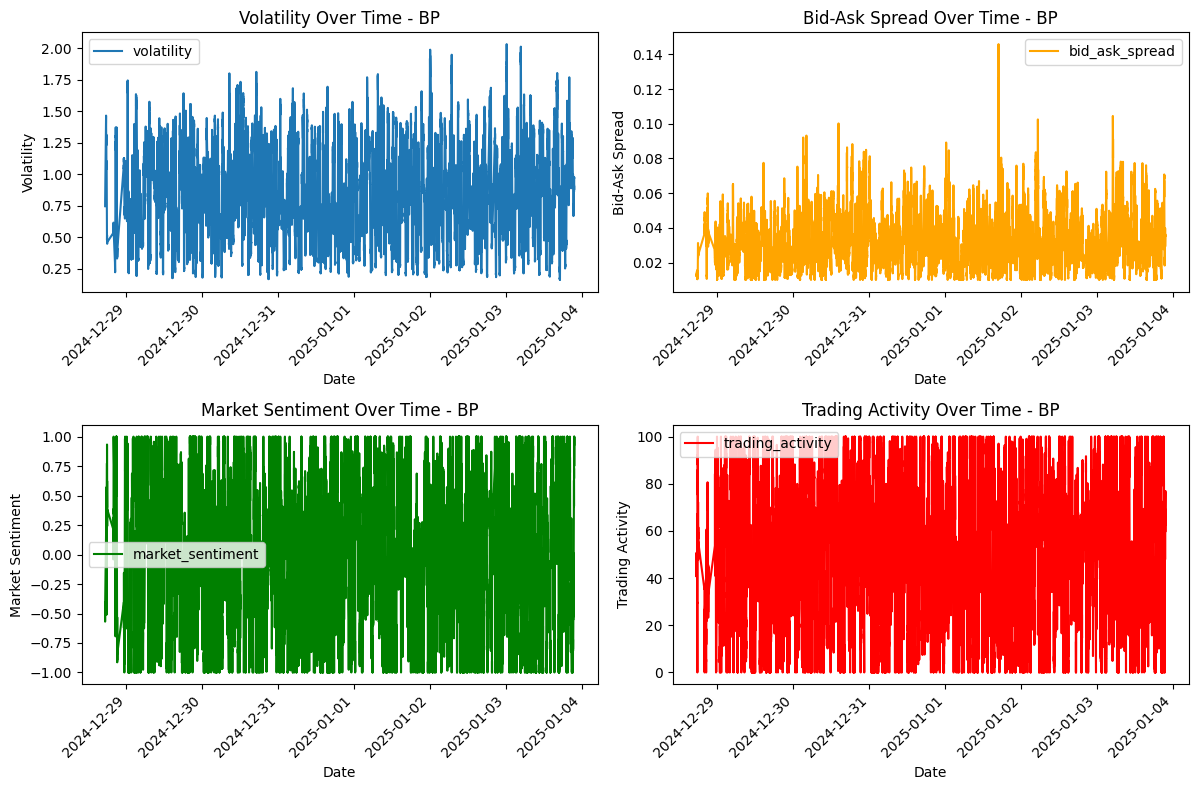

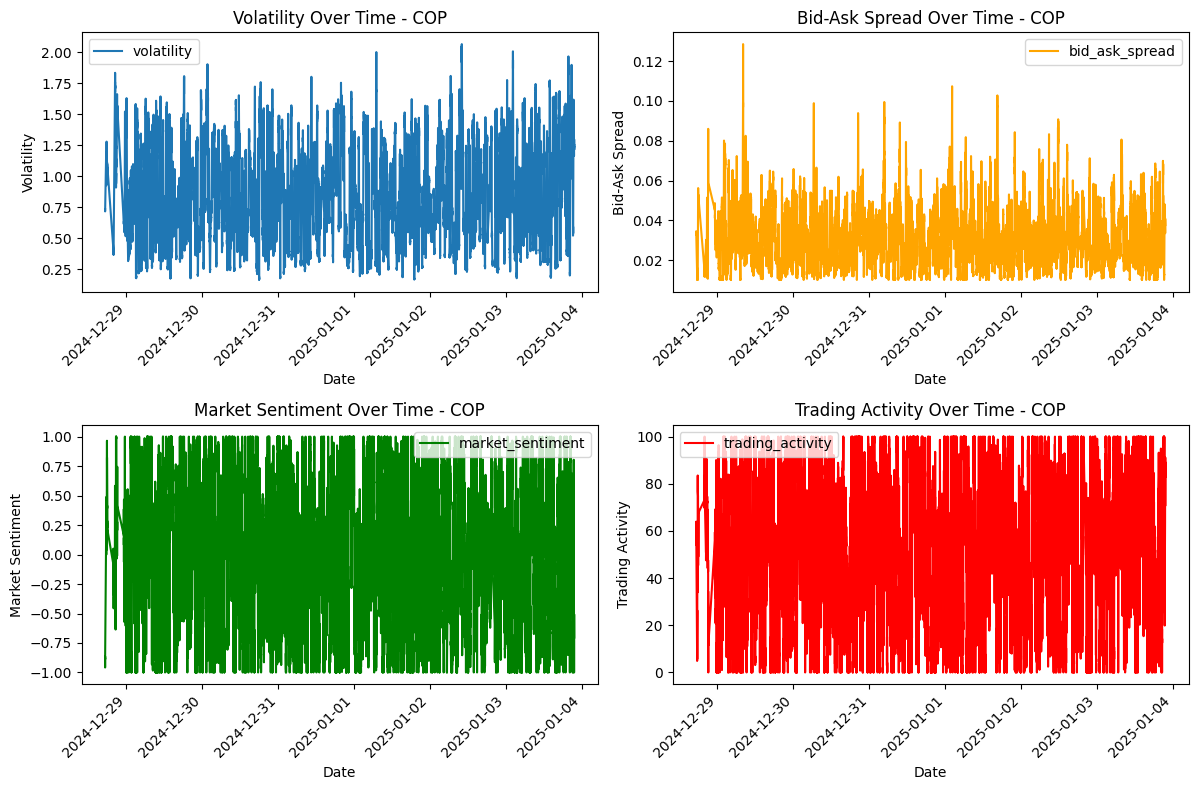

In [23]:
# Volatility, Bid-Ask Spread, Market Sentiment, and Trading Activity plots
for company in companies:
    # Filter data for the last 14 days and convert to Pandas DataFrame
    company_df = (
        yfinance_df
        .withColumn("update_timestamp", to_timestamp(col("update_timestamp")))  # Ensure it's a timestamp
        .filter(col("update_timestamp") >= date_sub(current_timestamp(), 14))
        .filter(col("company") == company)
        .orderBy("update_timestamp")  # Sort by timestamp
        .toPandas()
    )

    fig, axs = plt.subplots(2, 2, figsize=(12, 8))

    # Plot Volatility
    company_df.plot(x="update_timestamp", y="volatility", ax=axs[0, 0])
    axs[0, 0].set_title(f"Volatility Over Time - {company}")
    axs[0, 0].set_xlabel("Date")
    axs[0, 0].set_ylabel("Volatility")
    axs[0, 0].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))  # Format dates
    axs[0, 0].tick_params(axis='x', rotation=45)

    # Plot Bid-Ask Spread
    company_df.plot(x="update_timestamp", y="bid_ask_spread", ax=axs[0, 1], color="orange")
    axs[0, 1].set_title(f"Bid-Ask Spread Over Time - {company}")
    axs[0, 1].set_xlabel("Date")
    axs[0, 1].set_ylabel("Bid-Ask Spread")
    axs[0, 1].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))  # Format dates
    axs[0, 1].tick_params(axis='x', rotation=45)

    # Plot Market Sentiment
    company_df.plot(x="update_timestamp", y="market_sentiment", ax=axs[1, 0], color="green")
    axs[1, 0].set_title(f"Market Sentiment Over Time - {company}")
    axs[1, 0].set_xlabel("Date")
    axs[1, 0].set_ylabel("Market Sentiment")
    axs[1, 0].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))  # Format dates
    axs[1, 0].tick_params(axis='x', rotation=45)

    # Plot Trading Activity
    company_df.plot(x="update_timestamp", y="trading_activity", ax=axs[1, 1], color="red")
    axs[1, 1].set_title(f"Trading Activity Over Time - {company}")
    axs[1, 1].set_xlabel("Date")
    axs[1, 1].set_ylabel("Trading Activity")
    axs[1, 1].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))  # Format dates
    axs[1, 1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()
